# Introduction
In the movie industries, the investors or distribution companies invest on different kinds of movies and expect high returns. However, through our analysis of scraped data, a large proportion of movies even lost money. On the other hand, some movies without much investment displayed a high return on investment (ROI). The factors that may influence a movie's final return can come from a variety of sources, such as the movie budget, the genres, the actors/actress, the directors, and so on. Therefore, the investors need some method to estimate the possible return for their investment in a movie. Usually, the first thought to model this problem is to solve it as a regression task which estimates the final gross of a movie and then calculates the ROI according to the estimated ROI. We tried this method but it doesn't work very well. Then, we changed our approach and turned to model the distribution of possible returns and finally got a reasonable result.

## Project Content
- [Installing The Libraries](# Installing The Libraries)
- [Loading The Libraries](# Loading The Libraries)
- [Web Scrapping](# Web Scrapping)
- [Data Processing](# Data Processing)
- [Data Visualizing](# Data Visualizing)
- [Movie Box-office Prediction ](# Movie Box-office Prediction )

# Installing The Libraries
To get start, you need to install some required libraries that we used.

We used **Bokeh** to do the visualization, you need first install the **Bokeh** using the following command at a Bash or Windows Anacoda prompt:

````bash
conda install -c bokeh bokeh
````

## LoadingThe Libraries

In [10]:
import numpy as np
import pandas as pd
import io, time, json
import requests
import pickle
import html
import pickle
import operator
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from multiprocessing import Pool
from pprint import pprint
from multiprocessing import Pool
from datetime import datetime
from pprint import pprint
from bs4 import BeautifulSoup
from pprint import pprint
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
%matplotlib inline

# Web Scrapping
In this part, we scrapped data from different web resources including Rotten Tomatoes, IMDB and the Numbers. And then we merged them together to be our dataset. 

## I. Rotten Tomatoes

Before a movie is released, the rotten tomatoes website is one of the best sources to know the critic’s view to the movie’s quality. We wrote scrapers to scrap the rotten tomato ratings and all the critic reviews for each movie.

In [5]:
BASE_URL = "https://www.rottentomatoes.com/m/"
def get_rating(movie_name, BASE_URL=BASE_URL):
    url = BASE_URL + movie_name
    code, html = retrieve_html(url)
    soup = BeautifulSoup(html, 'html.parser')
    tomatometer = soup.find('span', {'class' : 'meter-value superPageFontColor'})
    value_span = tomatometer.find('span')
    rating = float(value_span.text) / 100
    return rating

def get_critic_reviews(movie_name, BASE_URL=BASE_URL):
    url_next = BASE_URL + movie_name + "/reviews"
    code, html = retrieve_html(url_next)
    
    reviews = []
    
    flag = True
    soup = BeautifulSoup(html, 'html.parser')
    count = soup.find('span', {'class' : 'pageInfo'}).text
    count = int(count.split(" ")[3])
    
    for i in range(count):
        review_containers = soup.findAll('div', {'class' : 'review_container'})
        
        for review_container in review_containers:
            label = review_container.div['class'][3]
            if label == 'rotten':
                label = 0 # negative review
            else:
                label = 1 # positive review
            review = review_container.find('div', {'class' : 'the_review'}).text
            reviews.append({'rating':label, 'review':review})
            
        url_next = soup.findAll('a', {'class' : 'btn btn-xs btn-primary-rt'})[1]['href']
        url_next = 'https://www.rottentomatoes.com' + url_next
        code, html = retrieve_html(url_next)
    
    return reviews

## II. IMDB

http://www.omdbapi.com/ provides a RESTful web service to obtain movie information, which enable users to easily retrieve useful movie data. By sending all data requests to: http://www.omdbapi.com/?apikey=[yourkey]& and append specified request parameters, movies's basic information are sent back as dictionary in response. 

By parsing the url response, we can get data that we expect.  

The codes of this part are much tedious, thus we hidden details and only provided funcions here. If you want to run the code, you may need to download the three python file from [here](https://github.com/yuechaohou/PDS-Final-Project/tree/master/rating).

In [48]:
from movie_data import *
from Rating import *
from Random_Forest import *
import re 

movies_names = get_movie_names_all()
new_names = get_match_names(movies_names)

We now got a list of matched names. In the next step, we set "t=moviename" in reuqest url to retrieves 'imdbRating','Rotten_Tomatoes','Metacritic','imdbVotes','plot' fields in respond content. The retrieved results are stored as a dataframe and savevd in "rating.csv".

In [45]:
def search_rating_via_IMDB(formal_names, names):
    parameters = {'i':'tt3896198',
                  'apikey':'22f49a17',
                  'plot': 'full'} 
    queryURL = "http://www.omdbapi.com/"
    
    separator = '?'
    
    for i in parameters:
        queryURL = queryURL+separator+i+"="+parameters[i]
        separator = '&'

    movie_rating = pd.DataFrame(columns=['name', 'imdbRating','Rotten_Tomatoes','Metacritic','imdbVotes','plot'])
    
    name = []
    imdbRating = []
    Rotten_Tomatoes = []
    Metacritic = []
    imdbVotes = []
    notfound = []
    plot = []
    
    for i in range(0, len(formal_names)):
        movie = names[i]
        name.append(formal_names[i])
        qword = re.sub(r' ', r'%20', movie).strip()
        query = queryURL + separator + "t=" + qword
        try:
            data = json.load(urllib2.urlopen(query))
            if data['Response'] == 'False':
                query = queryURL + separator + "t=" + qword.replace("and", "&")
                data = json.load(urllib2.urlopen(query))
                if data['Response'] == 'False':
                    idx = qword.find(':')
                    query = queryURL + separator + "t=" + qword[:idx]
                    data = json.load(urllib2.urlopen(query))
                    if data['Response'] == 'False':
                        idx = qword.find('(')
                        query = queryURL + separator + "t=" + qword[:idx]
                        data = json.load(urllib2.urlopen(query))
                        if data['Response'] == 'False':
                            print(str(i) +"  "+ movie)
                            Metacritic.append(None)
                            imdbRating.append(None)
                            Rotten_Tomatoes.append(None)
                            imdbVotes.append(None)
                            plot.append(None)
                            notfound.append(formal_names[i])
                            continue 
            Metacritic.append(getdata(data['Metascore']))
            imdbRating.append(getdata(data['imdbRating']))
            Rotten_Tomatoes.append(getRotTmt(data['Ratings']))
            imdbVotes.append(getdata(data['imdbVotes'].replace(',','')))
            plot.append(data['Plot'])
        except:
            Metacritic.append(None)
            imdbRating.append(None)
            Rotten_Tomatoes.append(None)
            imdbVotes.append(None)
            plot.append(None)
            notfound.append(formal_names[i])
    
    movie_rating.loc[:,'name'] = name
    movie_rating.loc[:,'imdbRating'] = imdbRating
    movie_rating.loc[:,'Rotten_Tomatoes'] = Rotten_Tomatoes
    movie_rating.loc[:,'Metacritic'] = Metacritic
    movie_rating.loc[:,'imdbVotes'] = imdbVotes
    movie_rating.loc[:,'plot'] = plot
    
    movie_rating.set_index('name', inplace=True)
    
    movie_rating.to_csv('ratings.csv')

    return movie_rating, notfound
    

movie_rating,notfound = search_rating_via_IMDB(movies_names, new_names)

## III. The Numbers
The web scrapper for [the number](https://www.the-numbers.com/) is based on the [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) parsing the html page. You could see all the code from [here](https://github.com/yuechaohou/PDS-Final-Project/blob/master/movie.py). It is not recommended to run all the web scrapping by yourself, since it is time-consuming.

Since we only put part of our web scrapping code here, to run the following code, you will need to download [the python file](https://github.com/yuechaohou/PDS-Final-Project/blob/master/movie.py) and put at the same location with this jupyter notebook.

In [24]:
#load the web scrapping code
from movie import *

This function will return a dictionary with all the movie information given the movie name. You may need to download the [name_url.pkl](https://github.com/yuechaohou/PDS-Final-Project/blob/master/feature_selection/name_url.pkl) file, if you want to run the code.

In [14]:
#get the movie information with the movie name(movie name+(year)), 
#The structure of the output is as following:
#   {'box_office': {'daliy': [{'Change':float, 
#                              'Date': datetime, 
#                              'Gross': int, 
#                              'Per Theater':int, 
#                              'Rank':int, 
#                              'Theaters':int,
#                              'Total Gross': int,
#                              'Week':int},... ],   
#                 'demostic': [{'Rank': int,
#                              'Record': string,
#                              'Revenue': int},...],
#                 'weekend': [{'Change': float,
#                             'Date': datetime,
#                             'Gross': int,
#                             'Per Theater': int,
#                             'Rank': int,
#                             'Theaters': int,
#                             'Total Gross': int,
#                             'Week': int},...],
#                 'weekly': [{'Change': float,
#                            'Date': datetime,
#                            'Gross': int,
#                            'Per Theater': int,
#                            'Rank': int,
#                            'Theaters': int,
#                            'Total Gross': int,
#                            'Week': int},...]},
#   'cast': {'cameos': [{'name': string,
#                      'url': string},...],
#            'leading_members': [{'name': string,
#                               'url': string},...],
#            'production': [{'name': string,
#                          'role': string,
#                          'url': string},...],
#            'supporting_cast': [{'name': string,
#                               'url': string},...],
#            'uncategorized': [{'name': string,
#                             'url': string},...]},
#   'international': {'Box Office Summary': [{'Maximum Theaters': int,
#                                           'Opening Weekend': int,
#                                           'Opening Weekend Theaters': int,
#                                           'Release Date': datetime,
#                                           'Report Date': datetime,
#                                           'Territory': sting,
#                                           'Theatrical Engagements': int,
#                                           'Total Box Office': int},...],
#                     'International Box Office': [{'Rank': int,
#                                                 'Record': string,
#                                                 'Revenue': int},...],
#                     'Worldwide Box Office': [{'Rank': int,
#                                             'Record': string,
#                                             'Revenue': int},...]},
#    'news': {'news': [string, ....]},
#    'summary': {'Budget': int,
#             'Creative Type': string,
#             'Domestic Releases': {'IMAX': datetime,        (may not have IMAX version)
#                                   'Wide': datetime},
#             'Franchise': string,
#             'Genre': string,
#             'International Releases': {location: {'Wide': datetime},...},   (may have IMAX version)
#             'Keywords':[string,...],
#             'MPAA Rating': string,
#             'Production Companies': [string,...],
#             'Production Countries': [string,...],
#             'Production Method': [string,...],
#             'Running Time': string,
#             'Source': string,
#             'Video Release': datetime,
#             'ranking on other records': [{'Amount': int,
#                                           'Chart Date': string,
#                                           'Days In Release': int,
#                                           'Rank': int,
#                                           'Record': string},...]}                 
#}
def get_info_with_name(name):
    with open('name_url.pkl', 'rb') as f:
        name_dic = pickle.load(f)
    
    name_info=get_info(name_dic[name]['url'])
    
    return name_info

# Data Processing
Our data comes from three resources, which are Rotten Tomatoes, IMDB, and The Numbers. These websites contain different kinds of data that could serve as features in our training set.

## The Numbers
We have scrapped 5517 movie information and save it in [the local pkl file](https://github.com/yuechaohou/PDS-Final-Project/blob/master/movie_info.pkl). You may need to download it and put it in the same location as this jupyter notebook if you want to run the code. 

In the following function, the statistical analysis was performed based on different features. The result of the function is saved as pkl files and are put [here](https://github.com/yuechaohou/PDS-Final-Project/tree/master/category_result). You can download them or you can run the following code.

In [16]:
#get the statistic information based on different categories
#may run several hours
#The structure of the output is as following:
#{ 'Genre': {keyword(genre name): [string(movie name),...],...},
#  'Creative Type': {keyword(type name): [string(movie name),...],...},
#  'Production Method':{keyword(method name): [string(movie name),...],...},
#  'Production Companies':{keyword(company name): [string(movie name),...],...},
#  'Production Countries':{keyword(country name): [string(movie name),...],...},
#  'Franchise':{keyword(franchise name): [string(movie name),...],...},
#  'Keywords':{keyword(keyword name): [string(movie name),...],...},
#  'cast':{keyword(actor name): [string(movie name),...],...},
#}
def get_all_movie_categories():
    movie_categories=dict()
    keyword, genre, prod, creat, company, country, cast =dict(), dict(), dict(), dict(), dict(), dict(), dict()
    franchise=dict()
    person_name_url=dict()
    
    
    with open('movie_info.pkl', 'rb') as f:
        movie_info = pickle.load(f)
    
    for name, dic in movie_info.items():
        summary_dic = dic['summary']
        if 'Genre' in summary_dic.keys():
            genre[summary_dic['Genre'].strip()]=genre.get(summary_dic['Genre'].strip(),[])+[name]
        if 'Creative Type' in summary_dic.keys():
            creat[summary_dic['Creative Type'].strip()]=creat.get(summary_dic['Creative Type'].strip(),[])+[name]
        if 'Production Method' in summary_dic.keys():
            for mt in summary_dic['Production Method']:
                prod[mt.strip()]=prod.get(mt.strip(),[])+[name]
                #print(prod.get(mt,[]))
        if 'Production Companies' in summary_dic.keys():
            for cp in summary_dic['Production Companies']:
                company[cp.strip()]=company.get(cp.strip(),[])+[name]
        if 'Production Countries' in summary_dic.keys():
            for ct in summary_dic['Production Countries']:
                country[ct.strip()]=country.get(ct.strip(),[])+[name]
        if 'Keywords' in summary_dic.keys():
            for keywords in summary_dic['Keywords']:
                keyword[keywords.strip()]=keyword.get(keywords.strip(),[])+[name]
        if 'Franchise' in summary_dic.keys():
            franchise[summary_dic['Franchise'].strip()]=franchise.get(summary_dic['Franchise'].strip(),[])+[name]
                

        cast_dic = dic['cast']
        if 'production' in cast_dic.keys():
            for person in cast_dic['production']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
                temp_dict={'role': person['role'],'name': name}
                cast[person_name]=cast.get(person_name,[])+[temp_dict]
                    
        if 'leading_members' in cast_dic.keys():
            for person in cast_dic['leading_members']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
                        
        if 'supporting_cast' in cast_dic.keys():
            for person in cast_dic['supporting_cast']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
            
        if 'cameos' in cast_dic.keys():
            for person in cast_dic['cameos']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
                        
        if 'uncategorized' in cast_dic.keys():
            for person in cast_dic['uncategorized']:
                person_name=person['name'].strip()
                if person_name not in person_name_url.keys():
                    person_name_url[person_name]=person['url']
        
    movie_categories['Genre']=genre
    movie_categories['Creative Type']=creat
    movie_categories['Production Method']=prod
    movie_categories['Production Companies']=company
    movie_categories['Production Countries']=country
    movie_categories['Keywords']=keyword
    movie_categories['Franchise']=franchise
    movie_categories['cast']=cast
    
    print('Writing...')
    with open('movie_categories.pkl', 'wb') as f:
        pickle.dump(movie_categories, f)
        
    with open('person_name_url.pkl', 'wb') as f:
        pickle.dump(person_name_url, f)
        
    return movie_categories

print(get_all_movie_categories().keys())

Writing...
dict_keys(['Genre', 'Creative Type', 'Production Method', 'Production Companies', 'Production Countries', 'Keywords', 'Franchise', 'cast'])


A visualization of the movie genre distribution is shown as following

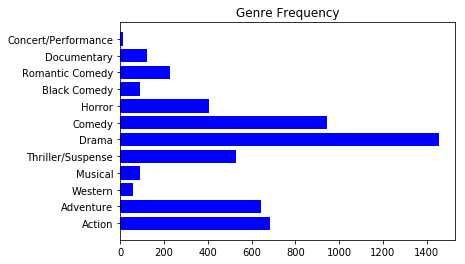

In [17]:
with open('movie_categories.pkl','rb') as f:
    cate_info=pickle.load(f)

dic=cate_info['Genre']
name_list =  list(dic.keys())
num_list = [len(a) for a in dic.values()]
plt.barh(range(len(num_list)), num_list,fc='b',tick_label=name_list)
plt.title('Genre Frequency')
plt.show()

To convert text features like keywords, genre and movie staff to numeric information, we define the following way to calculate the influence factor of these features.

For example, the company feature, we model the average past box office performance the company produced as the influcence factor the company contribute to the final box office. The formula is as following:

$$
IF_i=log(\frac{\sum_{(i,j)\in D} BF_{j}}{|D_{(i,j)}|+0.1 }+1)
$$
where the $BF_j$ means the box office of movie $ M_j$.

$D_{(i,j)}$ means the company $C_i$ produced the movie $M_j$ in the dataset. 

The following is the code implementation and the visualization result. To run the code, you may need to download the [movie_info.pkl](https://github.com/yuechaohou/PDS-Final-Project/blob/master/feature_selection/movie_info.pkl), [person_info.pkl](https://github.com/yuechaohou/PDS-Final-Project/blob/master/feature_selection/person_info.pkl) and [name_url.pkl](https://github.com/yuechaohou/PDS-Final-Project/blob/master/feature_selection/name_url.pkl)

[('China Film Company', 20.409429556800788), ('Wanda Pictures', 20.42585515967782), ('Syncopy', 20.460710614331887), ('Fuji Television Network', 20.507848280283877), ('Lightstorm Entertainment', 20.542933952125612), ('Duncan Henderson Productions', 20.602386917266767), ('Tom DeSanto', 20.644304453252747), ('Don Murphy', 20.644304453252747), ('Eon Productions', 20.66953745286486), ('B23', 20.732790318452746)]
2739


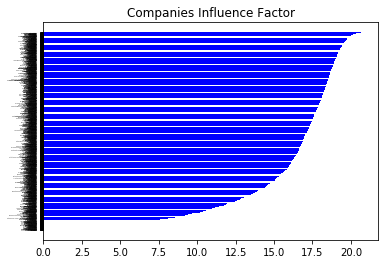

In [18]:
import math
with open('movie_info.pkl','rb') as f:
    movie_info=pickle.load(f)
    
with open('name_url.pkl','rb') as f:
    movie_budget=pickle.load(f)
    
def get_company_info_helper(name, movie_info=movie_info, movie_budget=movie_budget):
    
    company_name_info=dict()
    cast_dic=movie_info[name]['summary']
    if name in movie_budget.keys() and movie_budget[name]['Release Date']<datetime.now():
        if 'Production Companies' in cast_dic.keys():
            for company in cast_dic['Production Companies']:
                #print(name, company.strip())
                bo=movie_budget[name]['Worldwide Gross']
                company_name_info[company.strip()]=company_name_info.get(company.strip(),[])+[bo]
    
    return company_name_info

def get_all_company_info():
    with open('movie_info.pkl', 'rb') as f:
        movie_info=pickle.load(f)
    
    total_dic=dict()
    keys=list(movie_info.keys())
    pool = Pool(processes=10)
    pool_outputs = pool.map(get_company_info_helper,keys)
    pool.close()
    pool.join()
    
    for item in pool_outputs:
        for key, value in item.items():
            total_dic[key.strip()]=total_dic.get(key.strip(),[])+value
    
    #pprint(total_dic)
    company_info=dict()
    for key,value in total_dic.items():
        company_info[key]=math.log(np.sum(np.array(value))/(len(value)+0.1)+1)
    
    with open('company_info.pkl','wb') as f:
        pickle.dump(company_info, f)
        
    return    

get_all_company_info()
with open('company_info.pkl', 'rb') as f:
    company_info=pickle.load(f)

sorted_company=sorted(company_info.items(), key=lambda d: d[1])
print(sorted_company[-10:])

print(len(sorted_company))
target=sorted_company
name_list = [a[0] for a in target]
num_list = [a[1] for a in target]
plt.barh(range(len(num_list)), num_list,fc='b',tick_label=name_list)
plt.tick_params(axis='y',labelsize=1)
plt.title('Companies Influence Factor')
plt.show()

Totally, there are 2739 companies. The top first company with the highest influence factor is B23, who produced Skyfall in 2012 together with Eon Productions, Metro-Goldwyn-Mayer Pictures and Columbia Pictures.

We did similar calculation of influence factors for movie staff, keywords, production method, franchise, creative type and genre. You can find all the code from [here](https://github.com/yuechaohou/PDS-Final-Project/blob/master/feature_selection/Feature%20Selection.ipynb).

We selected budget, movie staff, keywords, production method, franchise, creative type, genre and production companies as the features to pass to our model. We exclude the movie with missing information and convert different features to the influence factor as we defined above.

In [3]:
visual_list=dict()

with open('movie_info.pkl', 'rb') as f:
    movie_info=pickle.load(f)
    
with open('person_info.pkl', 'rb') as f:
    person_info=pickle.load(f)
    
with open('name_url.pkl', 'rb') as f:
    movie_budget=pickle.load(f)

visual_y=list()
movie_name=list()
visual_list['budget']=list()
visual_list['cast']=list()
total_info=dict()
key_list=['Keywords', 'Production Method', 'Franchise', 'Creative Type', 'Genre', 'Production Companies']
for key in key_list:
    file_name='_'.join(key.lower().split())
    visual_list[file_name]=list()
    with open(file_name+'.pkl','rb') as f:
        total_info[file_name]=pickle.load(f)

for name in movie_info.keys():
    cast_dic=movie_info[name]['cast']
    cast_list=['leading_members', 'production']
    if name in movie_budget.keys() and movie_budget[name]['Release Date']<datetime.now():
        movie_name.append(name)
        test_value=math.log(movie_budget[name]['Worldwide Gross']+1)
        if test_value<15:
            visual_y.append('r')
        elif test_value<18:
            visual_y.append('b')
        else:
            visual_y.append('g')
            
        tmplist=list()
        for cate in cast_list:
            if cate in cast_dic.keys():
                for person in cast_dic[cate]:
                    person_name=person['name'].strip()
                    tmplist.append(person_info[person_name])
        
        visual_list['cast'].append(np.mean(np.array(tmplist)))
        visual_list['budget'].append(movie_budget[name]['Production Budget'])
        
        key_list=['Franchise', 'Creative Type', 'Genre']
        for key in key_list:
            file_name='_'.join(key.lower().split())
            if key in movie_info[name]['summary'].keys():
                cate=movie_info[name]['summary'][key].strip()
                visual_list[file_name].append(total_info[file_name][cate])
            else:
                visual_list[file_name].append(np.mean(np.array(list(total_info[file_name].values()) )))
        
        key_list=['Keywords', 'Production Method','Production Companies']
        for key in key_list:
            file_name='_'.join(key.lower().split())
            tmplist=list()
            if key in movie_info[name]['summary'].keys():
                for cate in movie_info[name]['summary'][key]:
                    tmplist.append(total_info[file_name][cate.strip()])
                visual_list[file_name].append(np.mean(np.array(tmplist)))
            else:
                visual_list[file_name].append(np.mean(np.array(list(total_info[file_name].values()) )))
                
P=np.array(list(visual_list.values())).T
column_name=np.array(list(visual_list.keys()))
visual_y=np.array(visual_y)
movie_name=np.array(movie_name)
movie_name=movie_name[~np.isnan(P).any(axis=1)]
y_train=visual_y[~np.isnan(P).any(axis=1)]
P=P[~np.isnan(P).any(axis=1)]
pdf=pd.DataFrame(data=P,index=movie_name, columns=column_name)
pdf.index.rename('name', inplace=True)
pdf.to_csv('movie_info.csv')

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Merge all the data
A tricky problem was that the movie names scrabed from https://www.the-numbers.com/ are not consistent with the movie name displayed on IMDB web pages. Additionally, only exact-matched movie names provided in request url is a valid search keyword. Thus, we have to convert movie names from what we scrabled to what are displayed in IMDB. We wrote codes to automatically transformed some names according to rules:
1. drop "(release year)" at the end of string 
2. replace "’" with "'"
3. replace '—' with ' - '
4. try to replace "and" with "&"
5. try to cut name before "()" or ":"

Some other incosistent names are namnually modified. Rest of incosistent names are directly threw away. 


To merge movie rating and staff factors, we throw away data that is deficient in either set. The final feature data cotains 4223 movies, including features:
* rating:   imdbRating, Rotten_Tomatoes, Metacritic, imdbVotes
* text:   plot (short description of movie, not used in following procedure)
* movie staff:  cast, director, franchise, production company, production_method
* budget
* kind: genre,  creative type, keywords

In [49]:
merge_rating_impactFactors()  # save all feature data to movie_data.csv
movie_data = pd.read_csv('movie_data.csv')

/Users/yuechaohou/Desktop/15688PracticalDataScience/assignment/pds_final/PDS-Final-Project/movie_data.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  select_rating[var][noneList] = avg


# Data Visualizing

Firstly, we will view the distributio of ROIs and Revenues of the movies in our dataset.

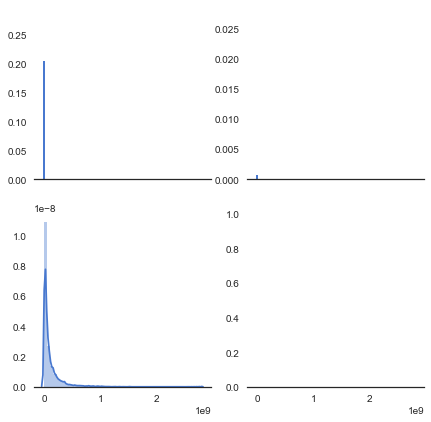

In [62]:
from translate_feature import get_revenues, get_ROIs
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set(style="white", palette="muted", color_codes=True)

revenues = sorted(get_revenues(), reverse=True)
rois = sorted(get_ROIs(), reverse=True)

revenues_to_display = [revenue[1] for revenue in revenues]
rois_to_display = [roi[1] for roi in rois]

f, axes = plt.subplots(2, 2, figsize=(7, 7), sharex=True)
sns.despine(left=True)

sns.distplot(rois_to_display[:100], ax=axes[0, 0])
sns.distplot(rois_to_display[100:], ax=axes[0, 1])
sns.distplot(revenues_to_display, ax=axes[1, 0])

From the graph above, we could see that our data is highly skewed. In this circumstance, use Kmeans to cluster will not be a very good choice, since we will get one or two clusters with the majority amount of mvoies. And this inference is verified after we use Kmeans to cluster the data according to ROIs or total gross.

In [65]:
kmeans1 = KMeans(n_clusters=6, random_state=0).fit(rois_to_display)
kmeans2 = KMeans(n_clusters=6, random_state=0).fit(revenues_to_display)

ValueError: could not convert string to float: '長江七號 (CJ7)(2008)'

After we observed our data distributions, we labeled our data using the following rules:
Based on ROi: [-0.9999749, 0), [0, 1), [1, 2), [2, 5), [5, 10), [10, 30), [30, ..).

Based on Gross:[0, 1000000), [1000000, 5000000), [5000000, 10000000), [10000000, 50000000), [50000000, 100000000), [100000000, 500000000), [500000000, 1000000000), [1000000000, ...)

Then, we label each movie according to which range their ROI

## Rating Data Visualization 
Now, we have got four kinds of rating data from imdb, rottentomato and metacritic and box-office of corresping movies. We could do some pre-pocessing and exploaratory analysis at this stage. 

Seaborn visulization comes wirth several nicely libraray that allows us to generate a nice scater matrix of our rating data.  PairGrid showa the interactions between variables. For our rating data set, we know that each type of ratings are probably going to be related; all these variable values and relationships  might vary by levels of box-office. Let's visualize results shown below:

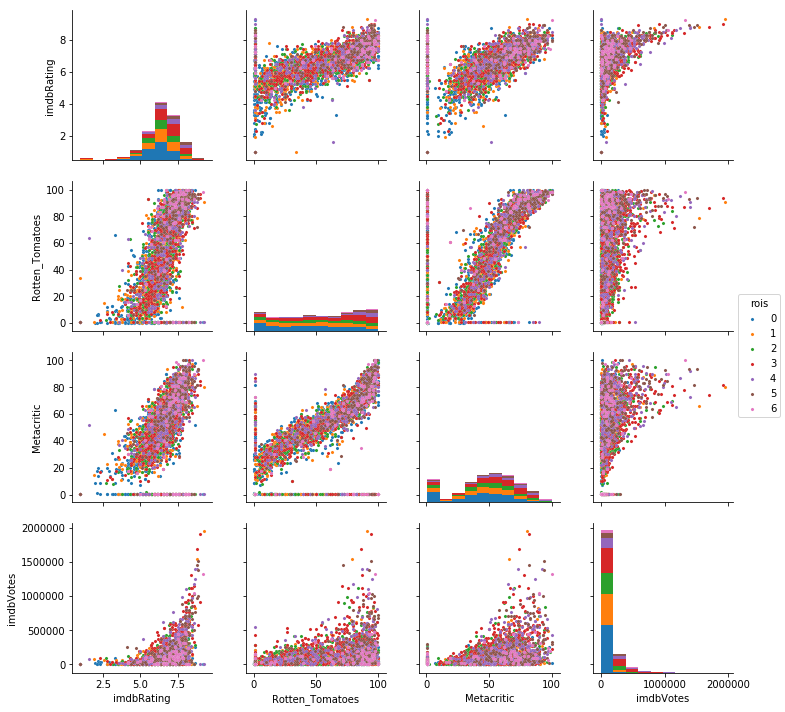

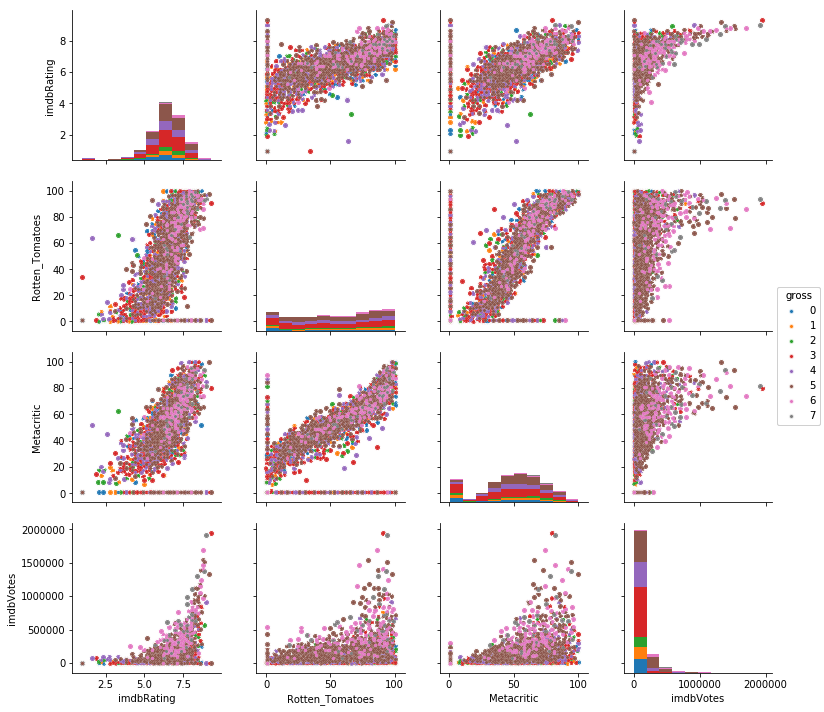

In [50]:
def rating_visl(movie_data):
    pyplot.figure(figsize=(25, 25)) # width and height in inches
    rois_pairplot = sns.PairGrid(movie_data, vars=["imdbRating", "Rotten_Tomatoes","Metacritic","imdbVotes"], hue='rois')
    rois_pairplot = rois_pairplot.map_diag(plt.hist, linewidth=0, edgecolor="w")
    rois_pairplot = rois_pairplot.map_offdiag(plt.scatter,  linewidth=0.1, edgecolor="w", s=10)
    rois_pairplot = rois_pairplot.add_legend()
    rois_pairplot.savefig("rois_pairplot.jpg")

    gross_pairplot = sns.pairplot(movie_data, vars=["imdbRating", "Rotten_Tomatoes","Metacritic","imdbVotes"], hue='gross')
    gross_pairplot = gross_pairplot.map_diag(plt.hist, linewidth=0, edgecolor="w")
    gross_pairplot = gross_pairplot.map_offdiag(plt.scatter,  linewidth=0.1, edgecolor="w", s=10)
    gross_pairplot = gross_pairplot.add_legend()
    gross_pairplot.savefig('gross_pairplot.jpg')
    
rating_visl(movie_data) # rating visualization 

From the pair-plot shown above, we can see the relationship between different rating values and final box-office. Movies that gained higher rating are more likely to gain higher gross. However, movies that has low bow-office received much dispersed reviews from audience. That means, some good movies are only favored by a small amount of people. Notice that the office-box is easily identifiable by imdbVotes, while others are much difficult to distinguish. This observation agrees with our final results drew from random forests.

## 3D visualization of Dataset

In this part, We tried to visualize the movie node with movie information as a 3-dimensional point. We used PCA to reduce the deminsion to 3 deminsion and label movies with different level of box office with different colors. The visualization is shown as following.

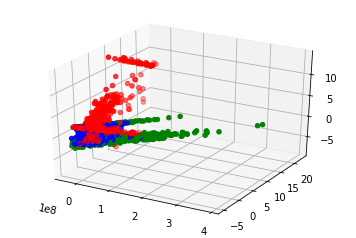

In [4]:
pca = PCA(n_components=3)
pca.fit(P)
P=pca.transform(P)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(P[:,0],P[:,1],P[:,2], c=y_train)
plt.show()

From the figure above, we can see that movies with the same level of box office approximately cluster together except for some outliers.

# Movie Box-office Prediction 
Now we want to predict the box-office performance of a movie.

## First attempt - predict the exact total gross

Our first attempt is to use cosine similarity and gated recurrent unit network to predict the final gross of a movie. Our approach is as follows:
    
Given a movie, we extract its features and generate a feature vector v for it. 
Then, we compute the cosine similarity between v and the feature vector of every movie in our dataset. Below is an interactive network graph we generated based on the cosine similarities between different movies. 

In [10]:
import networkx as nx

from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx
import scipy.spatial.distance as sp
from sklearn.preprocessing import normalize

data=pd.read_csv('movie_info.csv')
data=data.loc[:, data.columns != 'name'].as_matrix()
n=len(data)
threshold=100
dmatrix=np.zeros((n,n))
distance=sp.cdist(data,data)
print('starting')
for i in range(n):
    for j in range(n):
        if distance[i,j]<=threshold:
            dmatrix[i,j]=1

print('ending')
G=nx.from_numpy_matrix(dmatrix)
plot = figure(title="Network of Movie Nodes", x_range=(-0.5,0.5), y_range=(-0.5,0.5))

graph = from_networkx(G, nx.spring_layout, scale=3, center=(0,0))
plot.renderers.append(graph)

output_notebook()
print('visualizing')
show(plot)

starting
ending


Loading BokehJS ...

visualizing


/anaconda3/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


From the visualization above we can see that even though some movie nodes cluster together, overally the movie nodes are scattered. 

We choose the movies with which the cosine similarity is smaller than a specified threshold. Then, we extract the daily box offices of these movies and transform the data into time-series form.

In [6]:
def data_partition(data, N):
    num_rows = data.shape[0]
    x = []
    y = []
    for i in range(num_rows - N):
        temp = []
        for j in range(N):
            temp.append(data[i + j])
        x.append(np.array(temp))
        y.append(data[i + N])
    x = np.array(x)
    y = np.array(y)
    return x, y

def get_train_date_label(movies):
    data_train = []
    data_label = []
    
    for movie in movies:
        data = get_daily_box_offices(movie)
        x, y = data_partition(data, 3)
        data_train.extend(x)
        data_label.extend(y)
    
    data_train = np.array(data_train)
    data_label = np.array(data_label)
    
    return data_trian, data_label

We trained the following gru model using the obtained 

After the model is trained, we use the obtained model to predict the daily box offices during a specified time, let’s say 30 days. Then, we added up the predicted daily box offices, and calculated the estimated ROI.

## Second attempt - model the distribution of possible returns

In this attempt, instead of estimating the exact ROI, we try to model the possibilities of probable returns using three approaches, which are Random Forests, Support Vector Machines, and Neural Network.

In [51]:
def get_data_labels(movie_data):
    features = movie_data.drop(['rois', 'gross', 'name'], axis=1)
    rois = list(movie_data['rois'])
    gross = list(movie_data['gross'])
    features_tag = features.columns
    features = StandardScaler().fit_transform(features)
    return features, features_tag, rois, gross

def get_train_test_data(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.5, stratify=labels, random_state=1234)
    return X_train, X_test, y_train, y_test


movie_data = pd.read_csv('movie_data.csv')
print("the length of data :" + str(len(movie_data)))
features, features_tag, rois, gross = get_data_labels(movie_data)
X_train, X_test, y_train, y_test = get_train_test_data(features, gross)

the length of data :4223


## Random Forest 
Here, we tried several models to clssify our data, among which Random Forest performed best. It reaches accuracy at 64.2%.

Thus, we firstly look at what Random Forests are. They an ensemble learning method for classification, operated by constructing a multitude of decision trees at training time.
It firstly measures the variable importance in a data set to fit a random forest to the data. During the fitting process the out-of-bag error for each data point is recorded and averaged over the forest. The score for the j-th feature is computed and normalized by averaging the difference in out-of-bag error before and after the permutation over all trees. 

<img src='https://1.bp.blogspot.com/-q7Ut3QFRCtM/V1Qup7zYSrI/AAAAAAAAAKw/-53e6BIEDPgM9HARnZgcgfyCM02-WyCUQCLcB/s1600/random%2Bforest.jpg'>

Before using Random Forests to solve the classfication problem, we firstly scaled our data, then splited then into trainset and testset. Here, we are using 50/50 split - 2117 train movies and 2116 test movies. "RunRandomForest()" returns the trained model, predict accuracy and the posibility of each movies belong to one box-office range. We can also get the out-of-bag score computed by sklearn. It is an estimate of the classification accuracy we might expect to observe on new data.

In [52]:
def RunRandomForest( X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=12345)
    rf.fit(X_train, y_train)
    predicted = rf.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    probability = rf.predict_proba(X_test)
    return rf, accuracy, probability

rf, accuracy, probability = RunRandomForest(X_train, X_test, y_train, y_test)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.623
Mean accuracy score: 0.639


## Feature Importance Visualization
To better understand how features are attributed to the final decision, we use ".feature_importances_"  to get weight propotions that the model given to each feature. We then used radar plot to visulaized their importance. The plot image is shown below.

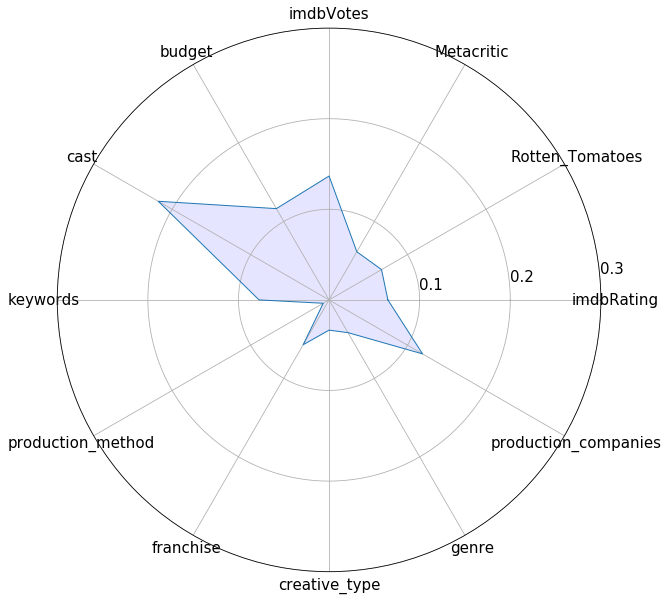

In [53]:
# Libraries
import matplotlib.pyplot as plt
from math import pi
from matplotlib import pyplot
 
def radar_plt_fimp(rf, features):
    # Set data
    featue_importance = list(zip(features, rf.feature_importances_))
    
    categories = []
    imp_val = []
    for imp in featue_importance:
        categories.append(imp[0])
        imp_val.append(imp[1])

    N = len(categories)

    # need to repeat the first value to close the circular graph:
    imp_val += imp_val[:1]

    # divide the plot / number of variable
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    pyplot.figure(figsize=(10, 10))
    ax = plt.subplot(111,polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=15)

    # Draw ylabels
    ax.set_rlabel_position(5)
    plt.yticks([0.1,0.2,0.3], ["0.1","0.2","0.3"], color="black", size=15)
    plt.ylim(0,0.3)

    # Plot data
    ax.plot(angles, imp_val, linewidth=1, linestyle='solid')
    ax.fill(angles, imp_val, 'b', alpha=0.1)

radar_plt_fimp(rf, features_tag)


From the plot above we can see that cast, production companies, imdbvotes are the most import features that dominate the movie's box office. imdbVotes's importance is far more than other ratings such as metacritc, rotten tomatoes and imdbratings. It give us some insights that as for box-office, public attention rate greatly overweights audience reviews. 

## Other Models

We also used multiclassifer and svc to realize classification. Both of them can reach accuracy over 59%. 

### MLPClassifier
A multilayer perceptron (MLP) is a class of feedforward artificial neural network. Given a set of features X = {x_1, x_2, ..., x_m} and a target y, it can learn a non-linear function approximator for either classification or regression. Different from other logistic regression, it has one activation layer that can distinguish data that is not linearly separable.

In [54]:
#****** MLPClassifier  ******#
from sklearn.neural_network import MLPClassifier

def RunMLPClassifier( X_train, X_test, y_train, y_test):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(20, ), random_state=1)
    clf.fit(X_train, y_train)    
    predicted = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    return clf, accuracy
    
clf, MLPCacc = RunMLPClassifier(X_train, X_test, y_train, y_test)
print(MLPCacc)
print(f'Mean accuracy score: {MLPCacc:.3}')

0.6013257575757576
Mean accuracy score: 0.601


## svc

Here we used Linear Support Vector Classification provided by "sklearn.svm". It implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

In [55]:
#****** SVM  ******#
from sklearn.svm import LinearSVC

def RunLinearSVC(X_train, X_test, y_train, y_test):
    svc = LinearSVC(random_state=3)
    svc.fit(X_train, y_train)   
    predicted = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    return svc, accuracy
    
svc, SVCacc = RunLinearSVC(X_train, X_test, y_train, y_test)
print(SVCacc)
print(f'Mean accuracy score: {SVCacc:.3}')

0.6013257575757576
Mean accuracy score: 0.601


## Neural Network

We als used Keras to construct a neural network model for predicting the probabilities of different probable returns.

In [56]:
def get_neural_mlc(input_dim, output_dim):
    model = Sequential()
    
    model.add(Dense(256, activation=backend.relu, input_dim=input_dim))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation=backend.relu))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation=backend.relu))
    model.add(Dropout(0.3))

    model.add(Dense(output_dim))
    model.add(Activation('softmax'))
    
    # print out the network architecture
    model.summary()
    
    model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
    
    return model

def run_neural_mlc(X_train, X_test, y_train, y_test, epochs):
    model = get_neural_mlc(X_train.shape[1], len(y_train[0]))
    model.fit(X_train, y_train, epochs=epochs)
    predictions = model.predict(X_test)
    count = 0
    for index, prediction in enumerate(predictions):
        print(np.argmax(prediction), np.argmax(y_test[index]))
        count += (np.argmax(prediction) == np.argmax(y_test[index]))
    accuracy = count / len(y_test)
    return model, accuracy

## Reference
